In [ ]:
# Imports & display options
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
sns.set(context="notebook", style="whitegrid")

PATH_META = "GSE62944_metadata.csv"
PATH_EXPR = "C:/Users/james/OneDrive/Documents/GitHub/Comp_BME_Module_3/Comp_BME_Module_3/GSE62944_subsample_log2TPM.csv"

ANGIO_GENES = ["VEGFA", "HIF1A", "ANGPT2", "FLT1"]
TP53_GENE = "TP53"

if not os.path.exists(PATH_META):
    raise FileNotFoundError(f"Metadata not found: {PATH_META}")
if not os.path.exists(PATH_EXPR):
    raise FileNotFoundError(f"Expression file not found: {PATH_EXPR}")

In [ ]:
# Load metadata
meta = pd.read_csv(PATH_META)

colmap = {}
for want, candidates in {
    "sample": ["sample", "sample_id", "SAMPLE", "tcga_sample", "rna_sample"],
    "cancer_type": ["cancer_type", "project", "cancer", "type", "disease"],
    "tissue": ["tissue", "sample_type", "TISSUE", "source_name", "is_tumor"],
}.items():
    for c in candidates:
        if c in meta.columns:
            colmap[want] = c
            break

missing = [k for k in ["sample", "cancer_type"] if k not in colmap]
if missing:
    raise ValueError(f"Missing columns {missing} in metadata.")

meta = meta.rename(columns={colmap["sample"]: "sample_id", colmap["cancer_type"]: "cancer_type"})
if "tissue" in colmap:
    meta = meta.rename(columns={colmap["tissue"]: "tissue"})

lung_meta = meta[meta["cancer_type"].isin(["LUAD", "LUSC"])].copy()
print(lung_meta["cancer_type"].value_counts())
print(f"Lung samples in metadata: {len(lung_meta):,}")

expr_header = pd.read_csv(PATH_EXPR, nrows=0)
expr_cols = expr_header.columns.tolist()
gene_col = expr_cols[0]
lung_ids = set(lung_meta["sample_id"])
keep_cols = [gene_col] + [c for c in expr_cols if c in lung_ids]

if len(keep_cols) <= 1:
    print("Example lung IDs:", list(lung_meta["sample_id"].head(5)))
    print("Example expr columns:", expr_cols[:8])
    raise ValueError("Sample IDs did not match between metadata and expression.")

expr = pd.read_csv(PATH_EXPR, usecols=keep_cols).set_index(gene_col)
lung_expr = expr[[c for c in expr.columns if c in lung_ids]]
lung_meta = lung_meta[lung_meta["sample_id"].isin(lung_expr.columns)]

print(f"Expression genes: {lung_expr.shape[0]:,}, lung samples: {lung_expr.shape[1]:,}")

def normalize_gene_index(idx):
    s = pd.Index(idx)
    s = s.str.replace(r"\.\d+$", "", regex=True)
    s = s.str.upper()
    s = s.str.replace(r"[^A-Z0-9_\-\.]", "", regex=True)
    return s

lung_expr.index = normalize_gene_index(lung_expr.index)

cancer_type
LUAD    80
LUSC    80
Name: count, dtype: int64
Lung samples in metadata: 160
Expression genes: 15,716, lung samples: 160


In [ ]:
# Map genes
symbol_to_ensembl = {
    "TP53": "ENSG00000141510",
    "HIF1A": "ENSG00000100644",
    "ANGPT2": "ENSG00000114771",
    "FLT1": "ENSG00000102755",
    "VEGFA": "ENSG00000112715",
}

def resolve_gene_name(symbol, expr_index):
    sym = symbol.upper()
    if sym in expr_index:
        return sym
    ens = symbol_to_ensembl.get(sym)
    if ens and ens in expr_index:
        return ens
    if ens and ens.split(".")[0] in expr_index:
        return ens.split(".")[0]
    return None

requested_genes = [TP53_GENE] + ANGIO_GENES
resolved_map = {g: resolve_gene_name(g, lung_expr.index) for g in requested_genes}
present_pairs = [(g, r) for g, r in resolved_map.items() if r is not None]

gene_mat = pd.DataFrame({sym: lung_expr.loc[r] for sym, r in present_pairs})
df = gene_mat.merge(
    lung_meta[["sample_id", "cancer_type"]],
    left_index=True, right_on="sample_id", how="left"
).set_index("sample_id")

print("df shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

df shape: (160, 6)
Columns: ['TP53', 'VEGFA', 'HIF1A', 'ANGPT2', 'FLT1', 'cancer_type']
                                  TP53     VEGFA     HIF1A    ANGPT2      FLT1 cancer_type
sample_id                                                                                 
TCGA-44-8117-01A-11R-2241-07  3.533095  9.701291  6.736848  3.030111  4.151444        LUAD
TCGA-50-5936-01A-11R-1628-07  5.960825  6.493070  6.753303  3.582496  4.130102        LUAD
TCGA-55-A494-01A-11R-A24X-07  6.236896  9.863876  5.849348  4.003857  4.178755        LUAD
TCGA-78-7160-01A-11R-2039-07  6.803066  6.842713  7.120642  2.753598  4.723887        LUAD
TCGA-78-7158-01A-11R-2039-07  7.446952  6.778299  6.417706  1.361158  2.384635        LUAD


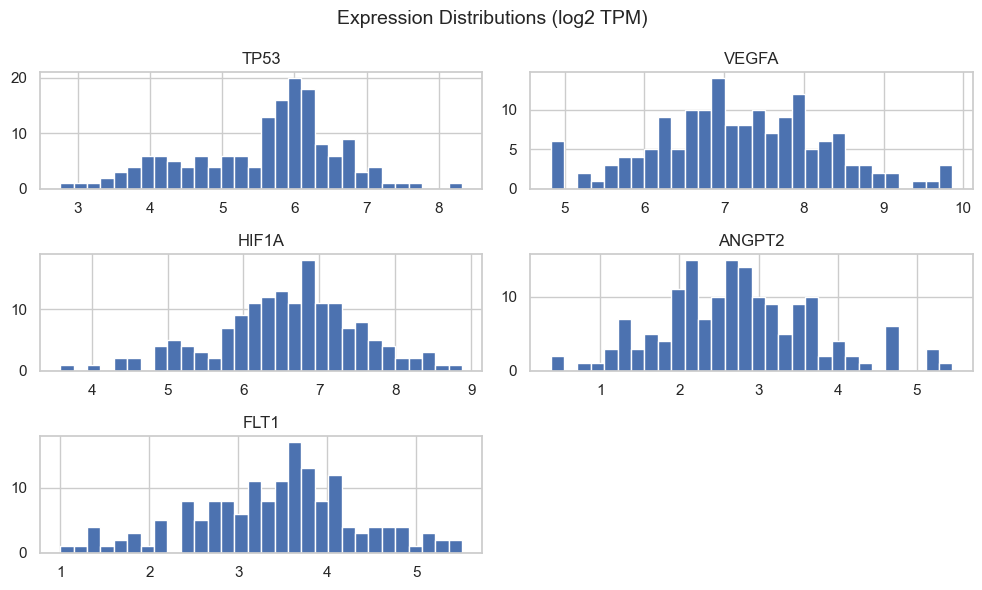

c:\Users\james\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\james\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\james\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\james\App

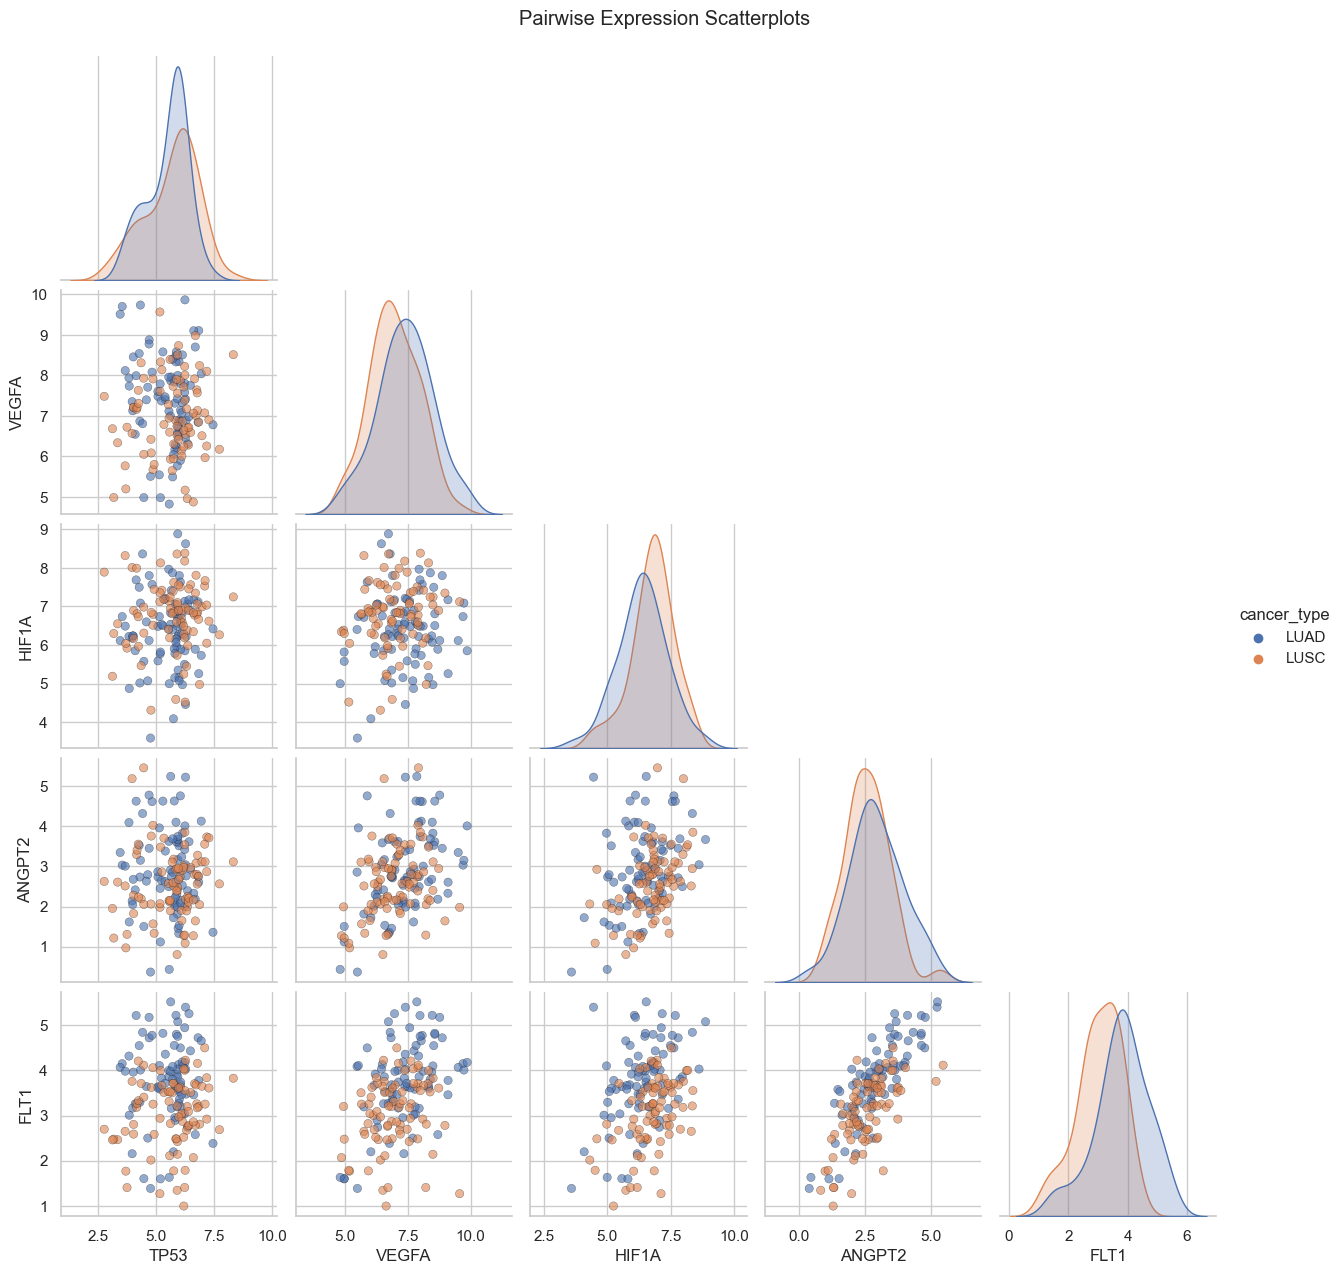

Spearman correlations (lung overall):
             TP53     VEGFA     HIF1A    ANGPT2      FLT1
TP53    1.000000 -0.034616  0.062859  0.020315  0.032245
VEGFA  -0.034616  1.000000  0.062821  0.380810  0.394044
HIF1A   0.062859  0.062821  1.000000  0.333546  0.275217
ANGPT2  0.020315  0.380810  0.333546  1.000000  0.742614
FLT1    0.032245  0.394044  0.275217  0.742614  1.000000


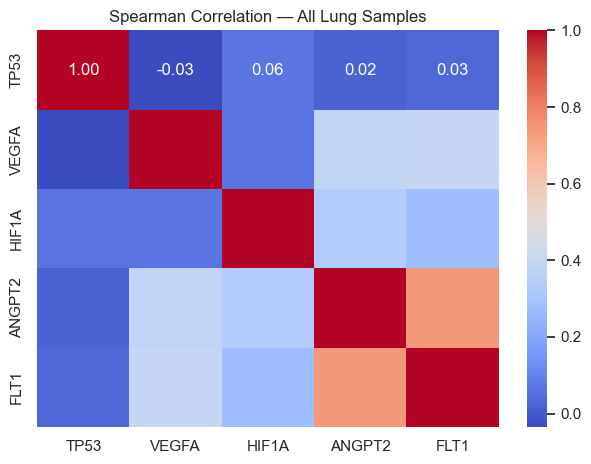

Label encoding: {'LUAD': np.int64(0), 'LUSC': np.int64(1)}

=== Logistic Regression (5-gene panel) — Test set ===
Accuracy: 0.844
F1-score: 0.848
ROC AUC : 0.934
PR  AUC : 0.952


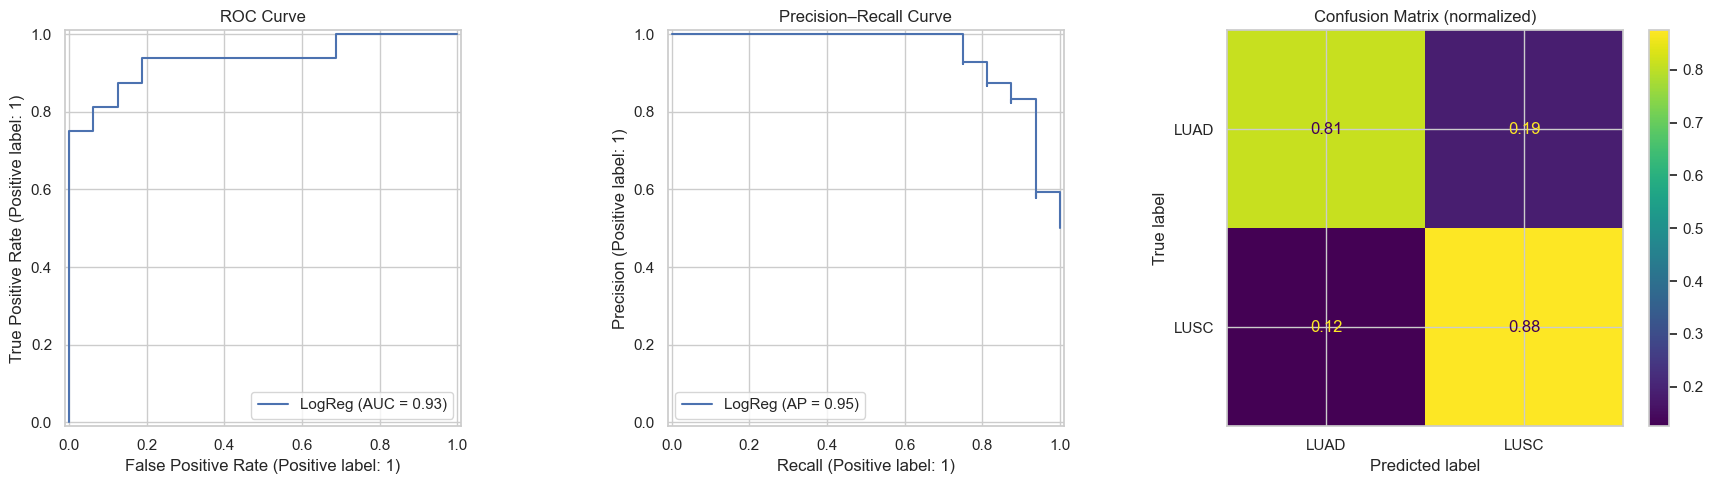


Top features by |coefficient|:
feature      coef
   FLT1 -1.608109
  HIF1A  0.628050
 ANGPT2  0.500068
   TP53  0.222143
  VEGFA -0.108949


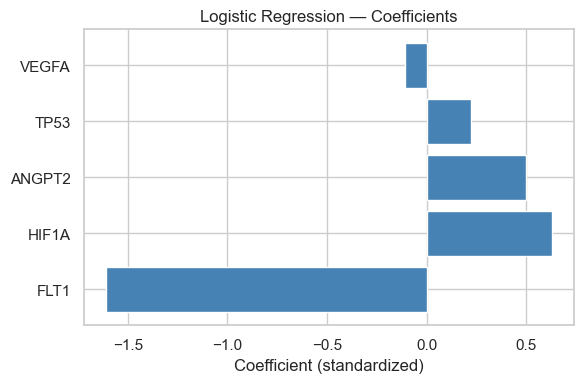

In [ ]:
# Exploratory Data Analysis (EDA)
plot_vars = [g for g in requested_genes if g in df.columns]

if len(plot_vars) >= 1:
    _ = df[plot_vars].hist(bins=30, figsize=(10, 6))
    plt.suptitle("Expression Distributions (log2 TPM)", fontsize=14)
    plt.tight_layout()
    plt.show()

if len(plot_vars) >= 2:
    sns.pairplot(
        df.reset_index(),
        vars=plot_vars,
        hue="cancer_type",
        corner=True,
        plot_kws={"alpha": 0.6, "edgecolor": "k", "linewidth": 0.3},
    )
    plt.suptitle("Pairwise Expression Scatterplots", y=1.02)
    plt.show()

if len(plot_vars) >= 2:
    corr_all = df[plot_vars].corr(method="spearman")
    print("Spearman correlations (lung overall):\n", corr_all)
    sns.heatmap(corr_all, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Spearman Correlation — All Lung Samples")
    plt.tight_layout()
    plt.show()

# Logistic Regression Model
features = [g for g in requested_genes if g in df.columns]
data_ml = df.dropna(subset=features + ["cancer_type"]).copy()
X = data_ml[features]
y = data_ml["cancer_type"]

# Encode LUAD/LUSC
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Label encoding:", dict(zip(le.classes_, le.transform(le.classes_))))

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        penalty="l2", solver="lbfgs", max_iter=5000, n_jobs=-1
    ))
])

# Fit/predict
pipe.fit(X_tr, y_tr)
y_pred = pipe.predict(X_te)
y_score = pipe.predict_proba(X_te)[:, 1]

acc  = accuracy_score(y_te, y_pred)
f1   = f1_score(y_te, y_pred)
auc  = roc_auc_score(y_te, y_score)
aupr = average_precision_score(y_te, y_score)

print("\n=== Logistic Regression (5-gene panel) — Test set ===")
print(f"Accuracy: {acc:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC : {auc:.3f}")
print(f"PR  AUC : {aupr:.3f}")

# validation
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
RocCurveDisplay.from_predictions(y_te, y_score, name="LogReg", ax=ax[0])
ax[0].set_title("ROC Curve")

PrecisionRecallDisplay.from_predictions(y_te, y_score, name="LogReg", ax=ax[1])
ax[1].set_title("Precision–Recall Curve")

ConfusionMatrixDisplay.from_predictions(
    y_te, y_pred, normalize="true", display_labels=le.classes_, ax=ax[2]
)
ax[2].set_title("Confusion Matrix (normalized)")
plt.tight_layout()
plt.show()

clf = pipe.named_steps["clf"]
coef_tbl = pd.DataFrame({"feature": features, "coef": clf.coef_[0]})
coef_tbl["abs_coef"] = coef_tbl["coef"].abs()
coef_tbl = coef_tbl.sort_values("abs_coef", ascending=False)

print("\nTop features by |coefficient|:")
print(coef_tbl[["feature", "coef"]].to_string(index=False))

plt.figure(figsize=(6,4))
plt.barh(coef_tbl["feature"], coef_tbl["coef"], color="steelblue")
plt.xlabel("Coefficient (standardized)")
plt.title("Logistic Regression — Coefficients")
plt.tight_layout()
plt.show()

In [ ]:
# LITERATURE VALIDATION:
# TP53 mutations are more prevalent in LUSC compared to LUAD (reported ranges: ~75-82% in LUSC vs. 47-60% in LUAD)
# Both VEGFA and ANGPT2 are higher in lung cancer  compared to normal, but their protein levels are  associated with tumor size and lymph node metastasis only in LUAD, not in LUSC. 
# Increased VEGFA and ANGPT2 expression is associated with lower survival in LUAD patients, but this connection is not seen in LUSC.
# Studies examining direct comparisons of expression levels between LUAD and LUSC emphasize the stronger associations in LUAD for HIF1A.
# This literature validation reinforces our finding that it is practical to use certain genes (TP53, VEGFA, HIF1A, ANGPT2, FLT1) as a trustworthy validation to distinguish LUAD and LUSC.
# With an AUC and AP values of 0.93 and 0.95 respectively, our validation suggests success when using these 5 genes to differentiate lung cancers.
# In addition, our confidence matrix shows both labels to be correct over 80% of the time.